### Investigating a dataset "Medical Appointment No Shows.  A dataset composed of medical appointments and 15 variables associated with each appointment, was compiled in Brazil.  This dataset is chosen to fulfill the requirements associated with Unit 1 Capstone.  Null hypothesis and alternate hypothesis are created from this dataset and explored.  The research proposal is proposed and expounded upon later in this notebook.

### Importing preliminary modules and reading the dataset.

In [1]:
#importing modules
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import collections
import statsmodels.stats.proportion
%matplotlib inline

In [2]:
#importng the target csv file
data = pd.read_csv('/Users/manueltanguma/Downloads/KaggleV2-May-2016.csv', encoding='latin-1')

In [3]:
#exploring the dataset and column names
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
data.shape

(110527, 14)

In [5]:
data.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [6]:
data.tail(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No


### The column names are addressed in the dataset to either correct spelling or make them more usable to myself.

In [7]:
#addressing column names to make them more readable
data.columns = [
    'patient_ID', 'appointment_ID', 'gender', 'scheduled_day',
    'appointment_day', 'age', 'neighbourhood', 'scholarship',
    'hypertension', 'diabetes', 'alcoholism', 'handicap', 'SMS_received',
    'no_show'
    ]

### A very preliminary look at the data in it's initial state, after changing column names.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0eb118d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a0ec11d68>]], dtype=object)

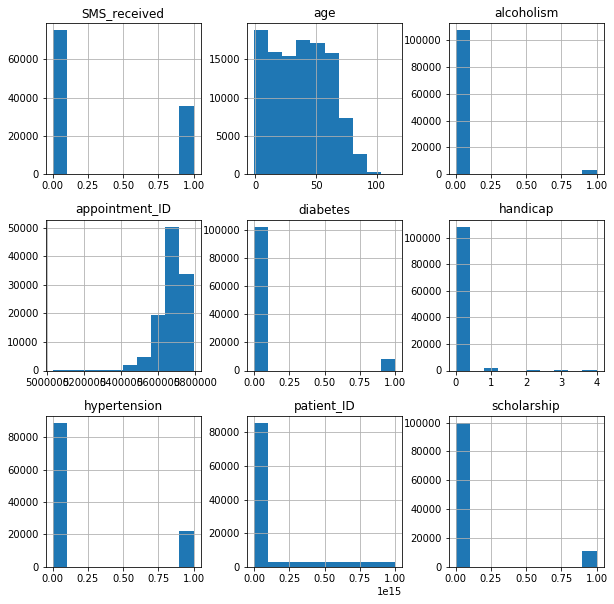

In [8]:
#quick look at some of the data
data.hist(figsize=(10, 10))

### Data manipulation and creation of new columns for anticipated use in later analysis.

### New column created. Scheduled hour.

In [9]:
#scheduled_day is when the the patient called and the appointment was made.  Converting to date-time series for 
#analysis and creating new column for anticipated future possible analysis
data.scheduled_day = pd.to_datetime(data.scheduled_day)
data['scheduled_hour'] = (
    data.scheduled_day.apply(lambda x : x.hour)
    )

### New columns created.  Lead days.  Appointment Day of the Week (what day the appointment falls on).  Lead days category (categorizing the amount of lead days before the appointment).

In [10]:
def get_day(datetime_object):
    '''This function returns only the date part of a datetime'''
    return datetime_object.date()

# Parse the date from string and create column lead_days
data.appointment_day = pd.to_datetime(data.appointment_day)

# Get lead_days column in timedelta64[ns] format
data['lead_days'] = (
    data.appointment_day.apply(get_day)
    - data.scheduled_day.apply(get_day)
    )
# Change the datatype of column lead_days into integer
data.lead_days = (
    (data.lead_days.astype('timedelta64[D]')).astype(int)
    )
# Create the new column appointment day-of-week column
data['appointment_DOW'] = (
    data.appointment_day.dt.dayofweek
    )

In [11]:
# Create lead_days_category column to be treated as a categorical value.
# Categoricals are a pandas data type corresponding to categorical variables in statistics. 
# A categorical variable takes on a limited, and usually fixed, number of possible values (categories; levels in R). 
# Examples are gender, social class, blood type, country affiliation, observation time or rating via Likert scales.
lead_days_labels = pd.Series([
    'A: Same day',
    'B: 1-2 days',
    'C: 3-7 days',
    'D: 8-31 days',
    'E: 32+ days'
    ])
data['lead_days_category'] = pd.cut(
    data.lead_days, bins = [-1, 0, 2, 7, 31, 999],
    labels = lead_days_labels,
    )

In [12]:
#looking at the dataframe with new columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 18 columns):
patient_ID            110527 non-null float64
appointment_ID        110527 non-null int64
gender                110527 non-null object
scheduled_day         110527 non-null datetime64[ns]
appointment_day       110527 non-null datetime64[ns]
age                   110527 non-null int64
neighbourhood         110527 non-null object
scholarship           110527 non-null int64
hypertension          110527 non-null int64
diabetes              110527 non-null int64
alcoholism            110527 non-null int64
handicap              110527 non-null int64
SMS_received          110527 non-null int64
no_show               110527 non-null object
scheduled_hour        110527 non-null int64
lead_days             110527 non-null int64
appointment_DOW       110527 non-null int64
lead_days_category    110522 non-null category
dtypes: category(1), datetime64[ns](2), float64(1), int64(11), object(3

In [13]:
data.head(3)

,patient_ID,appointment_ID,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,18,0,4,A: Same day
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,16,0,4,A: Same day
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,16,0,4,A: Same day


In [14]:
data.tail(3)

,patient_ID,appointment_ID,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category
110524,1.557663e+13,5630692,F,2016-04-27 16:03:52,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No,16,41,1,E: 32+ days
110525,9.213493e+13,5630323,F,2016-04-27 15:09:23,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No,15,41,1,E: 32+ days
110526,3.775115e+14,5629448,F,2016-04-27 13:30:56,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,No,13,41,1,E: 32+ days


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0ee13b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a0f4acf60>]], dtype=object)

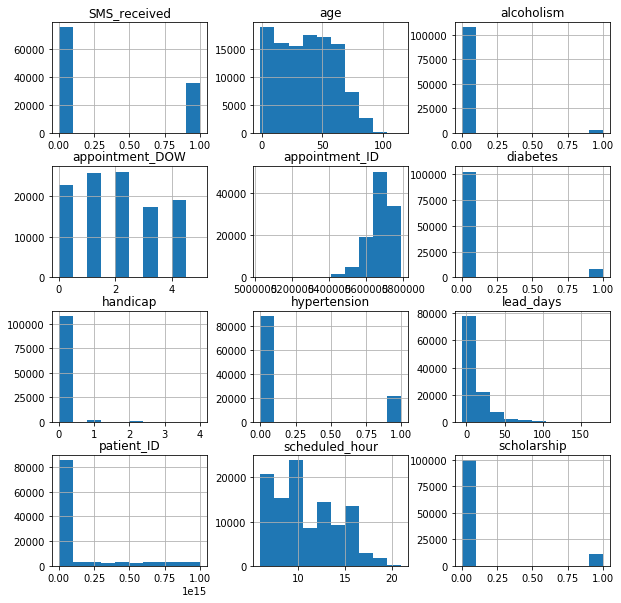

In [15]:
#taking another look at the data with the new columns
data.hist(figsize=(10, 10))

### Looking at other columns to try and glean other information to analyze.

In [16]:
#value counts for female and male
print('Patient population by gender: ')
data.gender.value_counts()

Patient population by gender: 


F    71840
M    38687
Name: gender, dtype: int64

In [17]:
# Taking a look at the patients with the most number of appointments in the dataset.
# To trim the 0s in the IDs
pd.set_option('display.float_format', '{:.0f}'.format) 
print('Patients who continuously utilized the medical system: ')
print(data.patient_ID.value_counts().iloc[0:20])
pd.set_option('display.float_format', '{:4f}'.format) 

Patients who continuously utilized the medical system: 
822145925426128    88
99637671331        84
26886125921145     70
33534783483176     65
258424392677       62
75797461494159     62
871374938638855    62
6264198675331      62
66844879846766     57
872278549442       55
89239687393655     54
8435223536         51
853439686798559    50
14479974122994     46
65433599726992     46
81894521843749     42
9452745294842      42
188232341789524    40
9496196639835      38
2271579924275      38
Name: patient_ID, dtype: int64


In [18]:
#creating another column called age group
data['age_group'] = (
    data.age.apply(lambda x: min(int(x / 10) , 9))
    )
data.age_group.value_counts().sort_index()

0    17476
1    12936
2    13699
3    15171
4    14209
5    15863
6    11876
7     5934
8     2946
9      417
Name: age_group, dtype: int64

In [19]:
#changing these columns into boolean for statistical and analytical purposes
columns_to_change = [
    'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'SMS_received'
    ]
for column in columns_to_change:
    data[column] = (data[column] == 1)


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
patient_ID            110527 non-null float64
appointment_ID        110527 non-null int64
gender                110527 non-null object
scheduled_day         110527 non-null datetime64[ns]
appointment_day       110527 non-null datetime64[ns]
age                   110527 non-null int64
neighbourhood         110527 non-null object
scholarship           110527 non-null bool
hypertension          110527 non-null bool
diabetes              110527 non-null bool
alcoholism            110527 non-null bool
handicap              110527 non-null int64
SMS_received          110527 non-null bool
no_show               110527 non-null object
scheduled_hour        110527 non-null int64
lead_days             110527 non-null int64
appointment_DOW       110527 non-null int64
lead_days_category    110522 non-null category
age_group             110527 non-null int64
dtypes: bool(5), category(1), da

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0fbb7780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a124b1588>]], dtype=object)

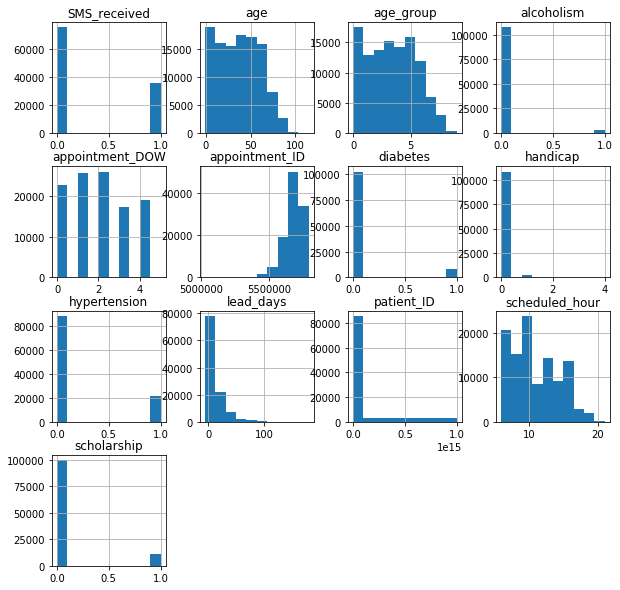

In [21]:
#taking another look at the data with the new columns
data.hist(figsize=(10, 10))

In [22]:
#looking at the number of neighborhoods in the dataframe
data.neighbourhood.value_counts()

JARDIM CAMBURI                  7717
MARIA ORTIZ                     5805
RESISTÃNCIA                    4431
JARDIM DA PENHA                 3877
ITARARÃ                        3514
CENTRO                          3334
TABUAZEIRO                      3132
SANTA MARTHA                    3131
JESUS DE NAZARETH               2853
BONFIM                          2773
SANTO ANTÃNIO                  2746
SANTO ANDRÃ                    2571
CARATOÃRA                      2565
JABOUR                          2509
SÃO PEDRO                      2448
ILHA DO PRÃNCIPE               2266
NOVA PALESTINA                  2264
ANDORINHAS                      2262
DA PENHA                        2217
ROMÃO                          2215
GURIGICA                        2018
SÃO JOSÃ                      1977
BELA VISTA                      1907
MARUÃPE                        1902
FORTE SÃO JOÃO                1889
ILHA DE SANTA MARIA             1885
SÃO CRISTÃVÃO                1836
R

In [23]:
#creating a new column for patient's who have a handicap vs no handicap
data['is_disabled'] = (data.handicap > 0)

### Transforming a key column into boolean values for anticipated analysis, with respect towards formulating research proposal and satisfying requirements of Unit 1 capstone.

In [24]:
#replacing yes and no with boolean values in the no-show column
boolean_replacement = {'Yes': True, 'No': False}
data.no_show.replace(boolean_replacement, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 20 columns):
patient_ID            110527 non-null float64
appointment_ID        110527 non-null int64
gender                110527 non-null object
scheduled_day         110527 non-null datetime64[ns]
appointment_day       110527 non-null datetime64[ns]
age                   110527 non-null int64
neighbourhood         110527 non-null object
scholarship           110527 non-null bool
hypertension          110527 non-null bool
diabetes              110527 non-null bool
alcoholism            110527 non-null bool
handicap              110527 non-null int64
SMS_received          110527 non-null bool
no_show               110527 non-null bool
scheduled_hour        110527 non-null int64
lead_days             110527 non-null int64
appointment_DOW       110527 non-null int64
lead_days_category    110522 non-null category
age_group             110527 non-null int64
is_disabled           110527 non-n

### Creating new dataframes for analysis if needed for research proposal.
### "Winners" - Patients that did show up for their appointments.
### "Slackers" - Patiens that did NOT show up for their appointments.
### "Yes_SMS" - Patients that did receive an SMS message reminder
### "No_SMS" - Patients that did NOT receive an SMS message reminder

In [25]:
#new dataframe populated only by patients that did show up for their appointment called "winners"
winners = data.loc[data['no_show'] == False]
winners.head(3)

,patient_ID,appointment_ID,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category,age_group,is_disabled
0,29872499824296.000000,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,0,False,False,18,0,4,A: Same day,6,False
1,558997776694438.000000,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,0,False,False,16,0,4,A: Same day,5,False
2,4262962299951.000000,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,False,False,False,False,0,False,False,16,0,4,A: Same day,6,False


In [26]:
#new dataframe populated only by patients that did NOT show up for their appointment called "slackers"
slackers = data.loc[data['no_show'] == True]
slackers.head(3)

,patient_ID,appointment_ID,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category,age_group,is_disabled
6,733688164476661.000000,5630279,F,2016-04-27 15:05:12,2016-04-29,23,GOIABEIRAS,False,False,False,False,0,False,True,15,2,4,B: 1-2 days,2,False
7,3449833394123.000000,5630575,F,2016-04-27 15:39:58,2016-04-29,39,GOIABEIRAS,False,False,False,False,0,False,True,15,2,4,B: 1-2 days,3,False
11,7542951368435.000000,5620163,M,2016-04-26 08:44:12,2016-04-29,29,NOVA PALESTINA,False,False,False,False,0,True,True,8,3,4,C: 3-7 days,2,False


In [27]:
print(winners.shape)
print(slackers.shape)

(88208, 20)
(22319, 20)


In [28]:
#new dataframe populated only by patients that did receive an sms message reminding them about upcoming appointment
yes_sms = data.loc[data['SMS_received'] == True]
yes_sms.head(3)

,patient_ID,appointment_ID,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category,age_group,is_disabled
11,7542951368435.000000,5620163,M,2016-04-26 08:44:12,2016-04-29,29,NOVA PALESTINA,False,False,False,False,0,True,True,8,3,4,C: 3-7 days,2,False
15,99948393975.000000,5620206,F,2016-04-26 08:47:27,2016-04-29,15,NOVA PALESTINA,False,False,False,False,0,True,False,8,3,4,C: 3-7 days,1,False
18,17135378245248.000000,5621836,F,2016-04-26 10:54:18,2016-04-29,30,NOVA PALESTINA,True,False,False,False,0,True,False,10,3,4,C: 3-7 days,3,False


In [29]:
#new dataframe populated only by patients that did NOT receive an sms message reminding them about upcoming appointment
no_sms = data.loc[data['SMS_received'] == False]
no_sms.head(3)

,patient_ID,appointment_ID,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category,age_group,is_disabled
0,29872499824296.000000,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,0,False,False,18,0,4,A: Same day,6,False
1,558997776694438.000000,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,0,False,False,16,0,4,A: Same day,5,False
2,4262962299951.000000,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,False,False,False,False,0,False,False,16,0,4,A: Same day,6,False


In [30]:
print(yes_sms.shape)
print(no_sms.shape)

(35482, 20)
(75045, 20)


### Making two dataframes, one composed of sampling 20,000 appointments from the patients that did not receive an SMS message and the other composed of 20,000 appointments from the patients that did receive an SMS message.

In [31]:
sample_no_sms = no_sms.sample(n=20000)
sample_no_sms.head(5)

,patient_ID,appointment_ID,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category,age_group,is_disabled
45779,46366413437993.000000,5737730,F,2016-05-25 09:58:22,2016-05-25,46,PARQUE MOSCOSO,False,False,False,False,0,False,False,9,0,2,A: Same day,4,False
40414,912139966799893.000000,5548837,M,2016-04-06 09:03:38,2016-05-18,58,SANTA MARTHA,False,False,False,False,0,False,False,9,42,2,E: 32+ days,5,False
52189,7338627618731.000000,5646304,F,2016-05-02 11:12:55,2016-05-04,51,SÃO JOSÃ,False,True,True,False,0,False,False,11,2,2,B: 1-2 days,5,False
2777,59823332932473.000000,5636744,M,2016-04-28 15:59:19,2016-04-29,19,ITARARÃ,False,False,False,False,0,False,False,15,1,4,B: 1-2 days,1,False
71655,282248231359179.000000,5699666,F,2016-05-16 08:43:19,2016-05-19,47,SÃO PEDRO,True,False,True,False,0,False,True,8,3,3,C: 3-7 days,4,False


In [32]:
sample_yes_sms = yes_sms.sample(n=20000)
sample_yes_sms.head(5)

,patient_ID,appointment_ID,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category,age_group,is_disabled
13159,1982647623244.000000,5561969,F,2016-04-08 11:47:24,2016-05-25,33,JUCUTUQUARA,False,False,False,False,0,True,True,11,47,2,E: 32+ days,3,False
96853,2526461185321.000000,5765933,F,2016-06-02 14:03:51,2016-06-08,55,MARUÃPE,False,False,False,False,0,True,False,14,6,2,C: 3-7 days,5,False
80304,462883229876782.000000,5620767,M,2016-04-26 09:25:08,2016-05-05,11,FONTE GRANDE,False,False,False,False,0,True,False,9,9,3,D: 8-31 days,1,False
96684,43667979561279.000000,5657444,F,2016-05-04 09:22:07,2016-06-07,4,CENTRO,False,False,False,False,0,True,False,9,34,1,E: 32+ days,0,False
34783,4524173934612.000000,5617066,M,2016-04-25 15:20:14,2016-05-05,1,TABUAZEIRO,False,False,False,False,0,True,False,15,10,3,D: 8-31 days,0,False


### The Research Proposal: 
#### A. How to decrease the "No-show" rate among patients making appointments to be seen by a medical professional?  Patients that do not show up for appointments, tie up precious medical resources including time taken away from other patients who would otherwise benefit from seeing a medical professional, tying up clinic personnel that would otherwise not be there, and frustrating medical personnel trying to help patients with their medical problems.  
#### B. The hypothesis here is that sms-messaging patients about their upcoming medical appointments will decrease the amount of "No-shows".
#### C. We will test this hypothesis by comparing the "No-show" rate among patients that did not receive a sms-message to the "No-show" rate among patients that did receive a sms-message.  This is an A/B manipulation where sms-messaging in employed and not employed.  We will compute the "No-show" rate for two months between the 2 groups and then compute the "No-show" rate after 6 months for the 2 groups.  If after the 2 month mark, there is a 10% decrease in the "No-show" rate, then that will be considered a success.  If after the 2 month mark, there is no change, then the study will run for another 4 monthsand the "No-show" rate will be examined.

### Rearranging the original dataframe by scheduled day from earliest to latest for use in answering the research proposal as outlined above.

In [33]:
#arranging the dataframe by scheduled day from earliest to latest
data = data.sort_values(by=['scheduled_day'])
data.head(5)

,patient_ID,appointment_ID,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category,age_group,is_disabled
3764,832256398961987.000000,5030230,F,2015-11-10 07:13:56,2016-05-04,51,RESISTÃNCIA,False,False,False,False,0,True,False,7,176,2,E: 32+ days,5,False
46292,91637474953513.000000,5122866,M,2015-12-03 08:17:28,2016-05-02,34,VILA RUBIM,False,True,False,False,0,True,True,8,151,0,E: 32+ days,3,False
102795,1216586867796.000000,5134197,F,2015-12-07 10:40:59,2016-06-03,27,SÃO CRISTÃVÃO,True,False,False,False,0,True,True,10,179,4,E: 32+ days,2,False
102797,31899595421534.000000,5134220,F,2015-12-07 10:42:42,2016-06-03,48,MARUÃPE,False,True,True,False,0,True,False,10,179,4,E: 32+ days,4,False
102796,9582232334148.000000,5134223,F,2015-12-07 10:43:01,2016-06-03,80,SÃO CRISTÃVÃO,False,True,True,False,0,True,False,10,179,4,E: 32+ days,8,False


In [34]:
data.tail(5)

,patient_ID,appointment_ID,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category,age_group,is_disabled
92442,729255235141745.000000,5790461,M,2016-06-08 19:32:25,2016-06-08,54,JARDIM CAMBURI,False,False,False,False,0,False,False,19,0,2,A: Same day,5,False
88146,947614361749238.000000,5790464,F,2016-06-08 19:32:56,2016-06-08,43,JARDIM CAMBURI,False,False,False,False,0,False,False,19,0,2,A: Same day,4,False
88147,356247857784.000000,5790466,M,2016-06-08 19:33:23,2016-06-08,27,JARDIM CAMBURI,False,False,False,False,0,False,False,19,0,2,A: Same day,2,False
87219,234131759175.000000,5790481,F,2016-06-08 19:58:52,2016-06-08,30,JARDIM CAMBURI,False,False,False,False,0,False,False,19,0,2,A: Same day,3,False
87223,5237164264312.000000,5790484,F,2016-06-08 20:07:23,2016-06-08,27,JARDIM CAMBURI,False,False,False,False,0,False,False,20,0,2,A: Same day,2,False


### Creating a dataframe to work with, composed of the first 2 months of observations.  

In [35]:
#Splitting the data into a dataframe representing the first 2 months of observations
data = data.set_index(['scheduled_day'])
two_months = data.loc['2015-11-10':'2016-01-10']
two_months.head(5)

,patient_ID,appointment_ID,gender,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category,age_group,is_disabled
scheduled_day,,,,,,,,,,,,,,,,,,,
2015-11-10 07:13:56,832256398961987.000000,5030230,F,2016-05-04,51,RESISTÃNCIA,False,False,False,False,0,True,False,7,176,2,E: 32+ days,5,False
2015-12-03 08:17:28,91637474953513.000000,5122866,M,2016-05-02,34,VILA RUBIM,False,True,False,False,0,True,True,8,151,0,E: 32+ days,3,False
2015-12-07 10:40:59,1216586867796.000000,5134197,F,2016-06-03,27,SÃO CRISTÃVÃO,True,False,False,False,0,True,True,10,179,4,E: 32+ days,2,False
2015-12-07 10:42:42,31899595421534.000000,5134220,F,2016-06-03,48,MARUÃPE,False,True,True,False,0,True,False,10,179,4,E: 32+ days,4,False
2015-12-07 10:43:01,9582232334148.000000,5134223,F,2016-06-03,80,SÃO CRISTÃVÃO,False,True,True,False,0,True,False,10,179,4,E: 32+ days,8,False


In [36]:
two_months.shape

(80, 19)

In [37]:
# How large is each group?
print('test sample size:', len(two_months[two_months.SMS_received == 1]))
print('control sample size:', len(two_months[two_months.SMS_received == 0]))
print('test proportion:', two_months.SMS_received.mean())
print()

# What is the (no show) signup rate of test and control?
print('test no-show rate:', two_months[two_months.SMS_received == 1].no_show.mean())
print('control no-show rate:', two_months[two_months.SMS_received == 0].no_show.mean())

# Is the experiment already significant?
stats.ttest_ind(
    two_months[two_months.SMS_received == 1].no_show,
    two_months[two_months.SMS_received== 0].no_show)

test sample size: 49
control sample size: 31
test proportion: 0.6125

test no-show rate: 0.30612244898
control no-show rate: 0.322580645161


Ttest_indResult(statistic=-0.1527995456453495, pvalue=0.87895094228417714)

Text(0,0.5,'NO-SHOW Day of Appointment')

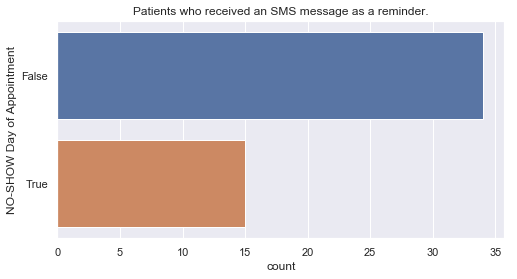

In [38]:
#Barplot (+)SMS-received and "no-show" count
plt.figure(figsize=(8,4))
sns.set(style="darkgrid")
ax = sns.countplot(y="no_show", data=two_months[two_months.SMS_received == 1])
ax.set_title('Patients who received an SMS message as a reminder.')
ax.set_ylabel('NO-SHOW Day of Appointment')

Text(0,0.5,'NO-SHOW Day of Appointment')

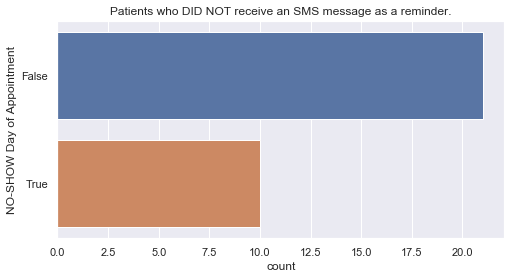

In [39]:
#Barplot (-)SMS-received and "no-show" count
plt.figure(figsize=(8,4))
sns.set(style="darkgrid")
ax = sns.countplot(y="no_show", data=two_months[two_months.SMS_received == 0])
ax.set_title('Patients who DID NOT receive an SMS message as a reminder.')
ax.set_ylabel('NO-SHOW Day of Appointment')

### After 2 months of implementation, the control group (patients that did NOT receive an SMS message to remind them of their medical appointment) had a No-Show Rate of: 32.2581%, while the test group (patients that did receive an SMS message to remind them of their medical appointment) had a No-Show Rate of: 30.6122%.  The t-test and p-value between these 2 groups are: -0.1528 and 0.8790, respectively.  At this point, I would say that my hypothesis of "Sending an SMS message to patients about their upcoming medical appointment, will decrease the No-Show Rate." is false.  There is not strong enough evidence to support this hypothesis.  The difference, in No-Show Rates, between the two groups is 1.6459%.

### Creating a dataframe to work with, composed of the first 6 months of observations.

In [40]:
#Splitting the data into a dataframe representing the first 6 months of observations
six_months = data.loc['2015-11-10':'2016-05-10']
six_months.head(5)

,patient_ID,appointment_ID,gender,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,SMS_received,no_show,scheduled_hour,lead_days,appointment_DOW,lead_days_category,age_group,is_disabled
scheduled_day,,,,,,,,,,,,,,,,,,,
2015-11-10 07:13:56,832256398961987.000000,5030230,F,2016-05-04,51,RESISTÃNCIA,False,False,False,False,0,True,False,7,176,2,E: 32+ days,5,False
2015-12-03 08:17:28,91637474953513.000000,5122866,M,2016-05-02,34,VILA RUBIM,False,True,False,False,0,True,True,8,151,0,E: 32+ days,3,False
2015-12-07 10:40:59,1216586867796.000000,5134197,F,2016-06-03,27,SÃO CRISTÃVÃO,True,False,False,False,0,True,True,10,179,4,E: 32+ days,2,False
2015-12-07 10:42:42,31899595421534.000000,5134220,F,2016-06-03,48,MARUÃPE,False,True,True,False,0,True,False,10,179,4,E: 32+ days,4,False
2015-12-07 10:43:01,9582232334148.000000,5134223,F,2016-06-03,80,SÃO CRISTÃVÃO,False,True,True,False,0,True,False,10,179,4,E: 32+ days,8,False


In [41]:
six_months.shape

(56881, 19)

In [42]:
# How large is each group?
print('test sample size:', len(six_months[six_months.SMS_received == 1]))
print('control sample size:', len(six_months[six_months.SMS_received == 0]))
print('test proportion:', six_months.SMS_received.mean())
print()

# What is the (no show) signup rate of test and control?
print('test no-show rate:', six_months[six_months.SMS_received == 1].no_show.mean())
print('control no-show rate:', six_months[six_months.SMS_received == 0].no_show.mean())

# Is the experiment already significant?
stats.ttest_ind(
    six_months[six_months.SMS_received == 1].no_show,
    six_months[six_months.SMS_received== 0].no_show)

test sample size: 22413
control sample size: 34468
test proportion: 0.394033156942

test no-show rate: 0.29197340829
control no-show rate: 0.228791922943


Ttest_indResult(statistic=16.964562681945321, pvalue=2.1645953342733006e-64)

Text(0,0.5,'NO-SHOW Day of Appointment')

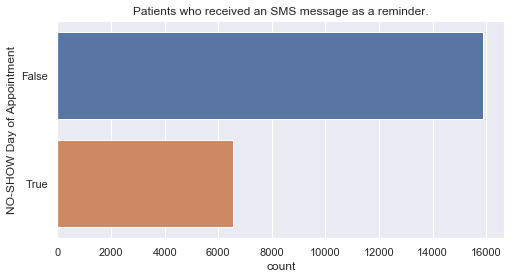

In [43]:
#Barplot (+)SMS-received and "no-show" count
plt.figure(figsize=(8,4))
sns.set(style="darkgrid")
ax = sns.countplot(y="no_show", data=six_months[six_months.SMS_received == 1])
ax.set_title('Patients who received an SMS message as a reminder.')
ax.set_ylabel('NO-SHOW Day of Appointment')

Text(0,0.5,'NO-SHOW Day of Appointment')

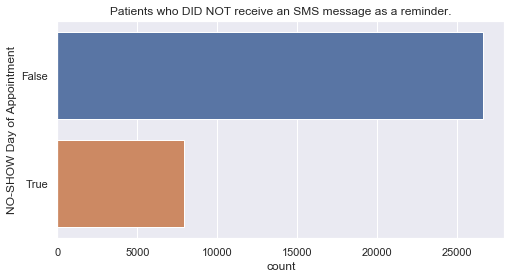

In [44]:
#Barplot (-)SMS-received and "no-show" count
plt.figure(figsize=(8,4))
sns.set(style="darkgrid")
ax = sns.countplot(y="no_show", data=six_months[six_months.SMS_received == 0])
ax.set_title('Patients who DID NOT receive an SMS message as a reminder.')
ax.set_ylabel('NO-SHOW Day of Appointment')

### After 6 months of implementation, the control group (patients that did NOT receive an SMS message to remind them of their medical appointment) had a No-Show Rate of: 22.8792%, while the test group (patients that did receive an SMS message to remind them of their medical appointment) had a No-Show Rate of: 29.1973%.  The t-test and p-value between these 2 groups are: 16.9646 and 2.1646, respectively.  At this point, I would say that my hypothesis of "Sending an SMS message to patients about their upcoming medical appointment, will decrease the No-Show Rate." is false.  There is not strong enough evidence to support this hypothesis.  The patients who did receive an SMS message about their upcoming medical appointment had a No-Show Rate of almost 30%.  Therefore, at the 6 month mark in the research proposal, it seems that sending an SMS message to patients about their upcoming medical appointment definitely does not work at decreasing the No-Show Rate.

### Creating the final dataframe to work with, with respect to answering the research proposal, composed of the entire timeline of the data.

In [45]:
# Now looking at the entire time in the dataframe aka "The Entire Experiment"
# How large is each group?
print('test sample size:', len(data[data.SMS_received == 1]))
print('control sample size:', len(data[data.SMS_received == 0]))
print('test proportion:', data.SMS_received.mean())
print()

# What is the (no show) signup rate of test and control?
print('test no-show rate:', data[data.SMS_received == 1].no_show.mean())
print('control no-show rate:', data[data.SMS_received == 0].no_show.mean())

# Is the experiment already significant?
stats.ttest_ind(
    data[data.SMS_received == 1].no_show,
    data[data.SMS_received== 0].no_show)

test sample size: 35482
control sample size: 75045
test proportion: 0.321025631746

test no-show rate: 0.275745448396
control no-show rate: 0.167033113465


Ttest_indResult(statistic=42.372270433329014, pvalue=0.0)

Text(0,0.5,'NO-SHOW Day of Appointment')

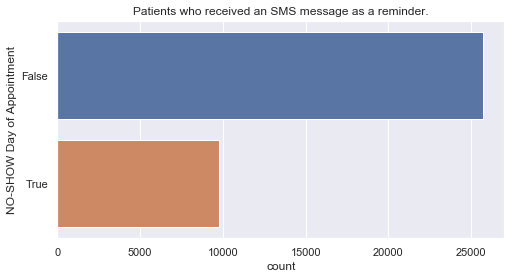

In [46]:
#Barplot (+)SMS-received and "no-show" count
plt.figure(figsize=(8,4))
sns.set(style="darkgrid")
ax = sns.countplot(y="no_show", data=data[data.SMS_received == 1])
ax.set_title('Patients who received an SMS message as a reminder.')
ax.set_ylabel('NO-SHOW Day of Appointment')

Text(0,0.5,'NO-SHOW Day of Appointment')

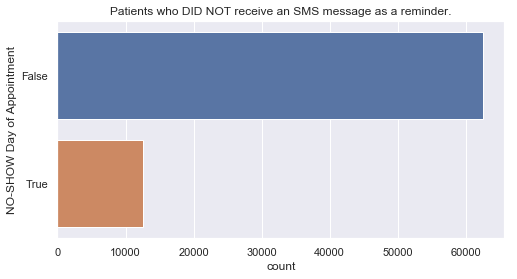

In [47]:
#Barplot (-)SMS-received and "no-show" count
plt.figure(figsize=(8,4))
sns.set(style="darkgrid")
ax = sns.countplot(y="no_show", data=data[data.SMS_received == 0])
ax.set_title('Patients who DID NOT receive an SMS message as a reminder.')
ax.set_ylabel('NO-SHOW Day of Appointment')

### After analyzing the data over the entire timeline, the control group (patients that did NOT receive an SMS message to remind them of their medical appointment) had a No-Show Rate of: 16.7033%, while the test group (patients that did receive an SMS message to remind them of their medical appointment) had a No-Show Rate of: 27.5745%.  The t-test and p-value between these 2 groups are: 42.3723 and 0.0, respectively.  I now say that my hypothesis of "Sending an SMS message to patients about their upcoming medical appointment, will decrease the No-Show Rate." is definitely false.  There is not strong enough evidence to support this hypothesis.  The patients who did receive an SMS message about their upcoming medical appointment had a No-Show Rate of 28%.  Therefore, at the end mark in the research proposal, it seems that sending an SMS message to patients about their upcoming medical appointment definitely does not work at decreasing the No-Show Rate.

### Graphs and visualizations of the data follows.

### Pie chart shown below showing that almost 30% of the patients that received an SMS message reminder did NOT show up at their medical appointment.

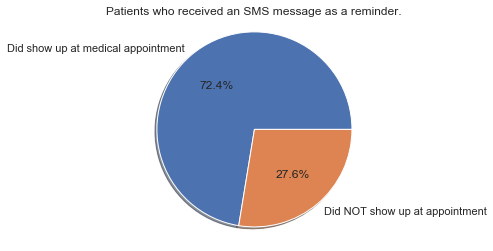

In [48]:
# pie chart patients that received an SMS message
labels = ['Did show up at medical appointment', 'Did NOT show up at appointment']
sizes = [yes_sms['no_show'].value_counts()[0],
         yes_sms['no_show'].value_counts()[1],
        ]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set_title('Patients who received an SMS message as a reminder.')
plt.show()

### Pie chart shown below showing that 17% of the patients that did NOT receive an SMS message reminder, did NOT show up at their medical appointment.

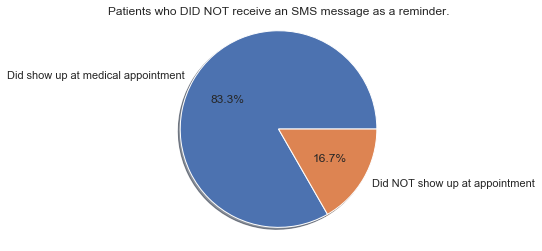

In [49]:
# pie chart patients that DID NOT receive an SMS message
labels = ['Did show up at medical appointment', 'Did NOT show up at appointment']
sizes = [no_sms['no_show'].value_counts()[0],
         no_sms['no_show'].value_counts()[1],
        ]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set_title('Patients who DID NOT receive an SMS message as a reminder.')
plt.show()

### FacetGrid showing relationship between SMS message received, and No-Show status, among patients with Government Funded Heathcare in Brazil.  The take-away here is that patients WITHOUT government assistance tend to keep their medical appointments versus those that do have government assistance with healthcare.

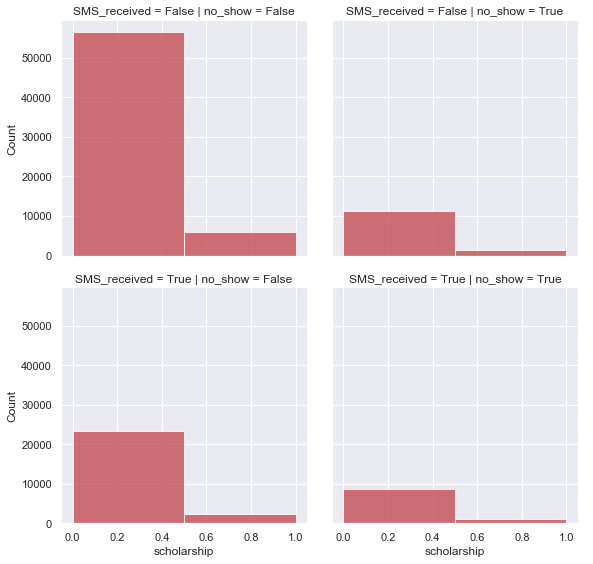

In [50]:
sns.set(style="darkgrid")
a = sns.FacetGrid(data, row='SMS_received', col='no_show', height=4)
a.map(plt.hist, 'scholarship', alpha=0.8, bins=2, color="r")
a.add_legend()
a.set_ylabels('Count')
plt.show()


### Horizontal bar graph illustrating solid evidence that patients who did not receive an SMS message did keep their medical appointment compared to patients that did receive an SMS message.

Text(0,0.5,'SMS Received by Patient')

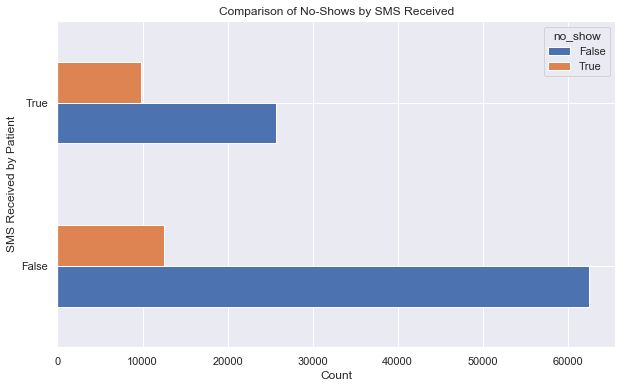

In [51]:
#horizontal bar graph showing No-Shows by SMS Received
x=data.groupby('no_show').SMS_received.value_counts().unstack(0).plot.barh(figsize=(10,6))
x.set_title('Comparison of No-Shows by SMS Received')
x.set_xlabel('Count')
x.set_ylabel('SMS Received by Patient')